#### CNN 이미지 분류 모델
- 이미지 데이터셋 준비
    * torchvision의 내장 데이터셋 활용 CIFIA10
- 이미지 분류 모델
    * 커스텀 CNN 구현

[1] 모듈 로딩 및 데이터 준비

In [2]:
## 모듈로딩
import torch
import torch.nn
from torchvision.datasets import CIFAR10    # torchvison 내장 데이터셋 관련 모듈
from torchvision.transforms import ToTensor  # torchvision 데이터 변환 관련 모듈
from torch.utils.data import DataLoader     # 데이터셋 관련 모듈 로딩

import matplotlib.pyplot as plt

In [3]:
## 데이터로딩
DIR_PATH = '../data/'

## Pytorch의 Dataset 형태 로딩
cifarDS = CIFAR10(DIR_PATH, train=True, download=True,
                  transform=ToTensor())

Files already downloaded and verified


In [4]:
# Dataset의 속성 확인
print(f'classes: {cifarDS.classes}')
print(f'cifarDS.class_to_idx: {cifarDS.class_to_idx}')
print(f'cifarDS.data.shape: {cifarDS.data.shape}')
print(f'len(cifarDS.targets): {len(cifarDS.targets)}')


classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cifarDS.class_to_idx: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
cifarDS.data.shape: (50000, 32, 32, 3)
len(cifarDS.targets): 50000


[2] 데이터 로더 
- 학습 시 배치크기 만큼 데이터와 라벨/타겟을 로딩

In [17]:
BATCH_SIZE = 53

cifar10DL = DataLoader(cifarDS)

tensor([6])
(3, 32, 32)
(32, 32, 3)


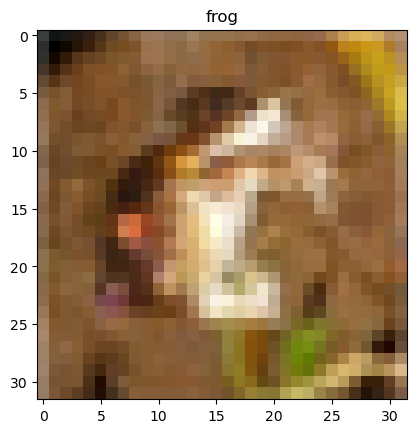

In [18]:
## [테스트] Dataset & DataLodaer
for data, target in cifar10DL:
    print(target)
    data = data.numpy().squeeze()
    print(data.shape)
    print(data.T.shape)
    plt.imshow(data.T)
    plt.title(cifarDS.classes[target.item()])
    break

[3]  커스텀 모델 설계 및 정의
- 모델목적 : 이미지 분류 모델
- 학습방법 : 지도학습 > 분류 > 다중분류 (10가지)
- 클래스이름 : ImageMCF
- 클래스구조 : 특징추출 부분 => CNN + 학습부분 FC
- 부모클래스 : nn.Module


In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
class ImageMCF(nn.Module):
    # 모델 구조 설계 즉, 생성자 메서드
    def __init__(self):
        # 부모 생성
        super().__init__()
        # 모델 층 구성              # 입력 1,3,32,32 => 1은 배치사이즈, 3은 채널, 32는 H, 32는 W
        # 특징 추출
        self.in_layer = nn.Conv2d(in_channels=3,out_channels= 10, kernel_size=3) # 입력이 RGB 라서 3 [1,10,30,30]
        self.in_layer = nn.Conv2d(in_channels=10,out_channels= 50, kernel_size=3)
        self.in_layer = nn.Conv2d(in_channels=50,out_channels= 10, kernel_size=3)
        self.p_layer = nn.MaxPool2d(kernel_size=2, stride=2)              # [1, 10, 15, 15]
        # 학습 관련 층
        self.h_layer = nn.Linear(in_features=10*15*15, out_features=50)
        self.out_layer = nn.Linear(in_features=50 , out_features=10)

    # 전방향/순방향 학습 메서드
    def forward(self, input):
        output = self.in_layer(input)
        print(f'[output 1] {output.shape}')

        output=F.relu(output)
        print(f'[output 2] {output.shape}')
        output=self.p_layer(output)
        print(f'[output 3] {output.shape}')

        # 4D - 2D (샘플수, 피쳐수)
        output=output.view(output.shape[0], -1)
        print(f'[output 4] {output.shape}')
        output=F.relu(self.h_layer(output))
        print(f'[output 5] {output.shape}')
        output=self.out_layer(output)     # crossEntropyLoss를 사용하니까 따로 활성화함수를 사용하지않음
        print(f'[output 6] {output.shape}')

        return output

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImageMCF2(nn.Module):
    def __init__(self):
        super().__init__()
        # 특징 추출 레이어
        self.cnn_layer = nn.Sequential(                       #[1, 3, 32, 32]
            nn.Conv2d(3, 10, 3),  # 입력 채널 3, 출력 채널 10  #[1, 10, 30, 30]  32-(3-1) =30
            nn.ReLU(),
            nn.Conv2d(10, 10, 3),  # 입력 채널 10, 출력 채널 10 #[1,10,28,28]    30-(3-1) = 28
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)  # 크기 절반으로 줄임           [1,10,14,14]
        )  # [1, 10, 15, 15]

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(10, 30, 3),  # 입력 채널 10, 출력 채널 30      [1,30,12,12]  14-(3-1)
            nn.ReLU(),
            nn.Conv2d(30, 10, 3),  # 입력 채널 30, 출력 채널 10      [1,10, 10,10]  12-(3-1)
            nn.ReLU(),
            nn.Conv2d(10, 30, 3),  # 입력 채널 10, 출력 채널 30      [1,30, 8, 8] 10-(3-1)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)  # 크기 절반으로 줄임         [1,30, 4, 4] 절반
        )  # [1, 30, 6, 6]

        # 마지막 레이어에서 커널 크기를 줄임
        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(30, 30, 2),  # 커널 크기를 (2x2)로 변경      [1,30,3,3] 4-(2-1) =3
            nn.ReLU(),
            nn.Conv2d(30, 10, 1),  # 커널 크기를 (1x1)로 변경      [1,10,3,3] 3-(1-1)
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)  # 크기 절반으로 줄임       [1,10,1 ,1 ] (3-2)/2 +1 =1  # 버림함 
        )  # [1, 10, 1, 1]

        # 학습 관련 층 (cnn_layer3의 출력 크기 10*1*1을 반영)
        self.h_layer = nn.Linear(10*1*1, 50)  # [1, 50]으로 변환
        self.out_layer = nn.Linear(50, 10)    # 출력층: 10 클래스

    def forward(self, input):
        output = self.cnn_layer(input)
        print(f'[cnn_layer out] {output.shape}')  # [1, 10, 15, 15]

        output = self.cnn_layer2(output)
        print(f'[cnn_layer2 out] {output.shape}')  # [1, 30, 6, 6]

        output = self.cnn_layer3(output)
        print(f'[cnn_layer3 out] {output.shape}')  # [1, 10, 1, 1]

        # 4D -> 2D 변환
        output = output.view(output.shape[0], -1)  # [배치 사이즈, 피쳐 수]
        print(f'[view output] {output.shape}')  # [1, 10*1*1]

        # 완전 연결층
        output = F.relu(self.h_layer(output))  # [1, 50]
        print(f'[h_layer output] {output.shape}')

        # 출력층
        output = self.out_layer(output)  # [1, 10]
        print(f'[out_layer output] {output.shape}')

        return output


In [22]:
## [테스트] 모델 인스턴스 생성
m=ImageMCF()
m2=ImageMCF2()

In [24]:
# 인스턴스 속성 읽기 => 인스턴스변수명.속성명
m.h_layer

Linear(in_features=2250, out_features=50, bias=True)

In [28]:
m.out_layer =nn.Linear(10,30)
for name, param in m.out_layer.named_parameters():
    print(name)
    print(param)

weight
Parameter containing:
tensor([[-0.0977,  0.0233, -0.1342, -0.2535, -0.2522, -0.0346,  0.0522, -0.2816,
         -0.2757,  0.2364],
        [-0.2875, -0.0483, -0.0301, -0.0130,  0.1479,  0.2260,  0.0625, -0.0237,
          0.0621,  0.1138],
        [ 0.1815,  0.2760,  0.2113,  0.2970, -0.2989,  0.1340, -0.2115,  0.2811,
         -0.2065,  0.2915],
        [-0.1677,  0.0748,  0.2798,  0.2373,  0.2075, -0.2390, -0.0679, -0.0147,
          0.2206,  0.2070],
        [ 0.0844, -0.2781, -0.2583, -0.2101, -0.1271, -0.2835,  0.1575,  0.0614,
         -0.0855,  0.0984],
        [-0.0476,  0.2753, -0.2474,  0.2689,  0.2789, -0.1989,  0.0331, -0.1520,
         -0.2853,  0.2311],
        [-0.1808,  0.0719,  0.0916, -0.1101, -0.1629,  0.2434,  0.0922, -0.2671,
          0.1963,  0.2479],
        [-0.1607, -0.2277, -0.1521,  0.0949, -0.2888, -0.2706,  0.2513,  0.2286,
          0.2491, -0.1845],
        [ 0.2729, -0.0052, -0.1789,  0.2309,  0.2434, -0.1577, -0.2934, -0.1828,
         -0.1779, 

In [11]:
from torchinfo import summary
summary(m2)


Layer (type:depth-idx)                   Param #
ImageMCF2                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       910
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       2,730
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       2,710
│    └─ReLU: 2-9                         --
│    └─Conv2d: 2-10                      2,730
│    └─ReLU: 2-11                        --
│    └─MaxPool2d: 2-12                   --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-13                      3,630
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      310
│    └─ReLU: 2-16                        --
│    └─AvgPool2d: 2-17                   --
├─Linear: 1-

In [15]:
## [테스트] Dataset & DataLoader
for data, target in cifar10DL:
    print(f'[target]=> {target}')
    print(data.shape)
    # 학습
    pre = m2(data)
    print(f'pre => {pre.argmax(dim=1)}')
    break

[target]=> tensor([6])
torch.Size([1, 3, 32, 32])
[cnn_layer out] torch.Size([1, 10, 14, 14])
[cnn_layer2 out] torch.Size([1, 30, 4, 4])
[cnn_layer3 out] torch.Size([1, 10, 1, 1])
[view output] torch.Size([1, 10])
[h_layer output] torch.Size([1, 50])
[out_layer output] torch.Size([1, 10])
pre => tensor([2])


In [13]:
## [테스트] Dataset & DataLoader
for data, target in cifar10DL:
    print(f'[target]=> {target}')
    print(data.shape)
    # 학습
    pre = m2(data)
    print(f'pre => {pre.argmax(dim=1)}')
    break

[target]=> tensor([6])
torch.Size([1, 3, 32, 32])
[cnn_layer out] torch.Size([1, 10, 14, 14])
[cnn_layer2 out] torch.Size([1, 30, 4, 4])
[cnn_layer3 out] torch.Size([1, 10, 1, 1])
[view output] torch.Size([1, 10])
[h_layer output] torch.Size([1, 50])
[out_layer output] torch.Size([1, 10])
pre => tensor([2])


In [14]:
for name, param in m.named_parameters():
    print(f'[{name}]---------\n{param.shape}')

[in_layer.weight]---------
torch.Size([10, 50, 3, 3])
[in_layer.bias]---------
torch.Size([10])
[h_layer.weight]---------
torch.Size([50, 2250])
[h_layer.bias]---------
torch.Size([50])
[out_layer.weight]---------
torch.Size([10, 50])
[out_layer.bias]---------
torch.Size([10])
